In [314]:
from typing import Dict, Callable
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import ticker as mtick
from matplotlib.patches import Patch
import seaborn as sns

In [315]:
world_bank_data = pd.read_excel('P_Data_Extract_From_World_Development_Indicators.xlsx')

In [316]:
year_start = 1991
year_end = 2019
# gdp_measure = 'NY.GDP.PCAP.KD'
# gdp_measure = 'NY.GDP.PCAP.CD'
gdp_measure = 'NY.GDP.PCAP.PP.KD'
# gdp_measure = 'NY.GDP.PCAP.PP.CD'
pop_measure = 'SP.POP.TOTL'

In [317]:
gdp_label = \
    world_bank_data\
        .query(f'`Series Code` == "{gdp_measure}"')\
        ['Series Name']\
        .unique()\
        [0]
gdp_label

'GDP per capita, PPP (constant 2017 international $)'

In [318]:
def year_column(year: int) -> str:
    return f'{year} [YR{year}]'
gdp = {}
pop = {}
gdp[str(year_start)] = \
    world_bank_data\
        .query(f'`Series Code` == "{gdp_measure}"')\
        [['Country Name', 'Country Code', year_column(year_start)]]
gdp[str(year_end)] = \
    world_bank_data\
        .query(f'`Series Code` == "{gdp_measure}"')\
        [['Country Name', 'Country Code', year_column(year_end)]]
pop[str(year_start)] = \
    world_bank_data\
        .query(f'`Series Code` == "{pop_measure}"')\
        [['Country Name', 'Country Code', year_column(year_start)]]
pop[str(year_end)] = \
    world_bank_data\
        .query(f'`Series Code` == "{pop_measure}"')\
        [['Country Name', 'Country Code', year_column(year_end)]]


In [319]:
def get_country_by_code(code: str) -> str:
    return str(world_bank_data.query(f'`Country Code` == "{code}"')['Country Name'].unique()[0])


## Replicate the Economist Analysis

In [320]:
query_territories = '`Country Code`.isin(["TEA", "TEC", "TLA", "TMN", "TSA", "TSS"])'
query_economist = '`Country Code`.isin(["USA", "JPN", "CHN", "FRA", "DEU", "GBR", "AUT", "ESP", "LUX", "ITA", "IRL"])'

In [321]:
def group_economist(country_code: str) -> str:
    if country_code in ["FRA", "DEU", "GBR", "AUT", "ESP", "LUX", "ITA", "IRL",]:
        return "Western Europe"
    else:
        return country_code

In [322]:
def get_chart_data(gdp: Dict[str, pd.DataFrame], 
                   pop: Dict[str, pd.DataFrame], 
                   year: int,
                   query: str,
                   grouping: Callable,
                   sorting: dict):
    chart_data =\
        gdp[str(year)]\
            .query(query)\
            .rename(columns={year_column(year): 'GDP per Capita'})\
            .merge(
                pop[str(year)]\
                    .query(query)\
                    .rename(columns={year_column(year): 'Population'}),
                how='inner',
                on=['Country Code']
            )
    chart_data['Region'] = chart_data['Country Code'].apply(grouping)
    chart_data =\
        chart_data\
            .groupby('Region')\
            .apply(
                lambda x: pd.Series([
                    np.sum(x['Population']),
                    np.average(x['GDP per Capita'], weights=x['Population']),
                ], index=['Population', 'GDP per Capita'])
            )\
            .reset_index()\
            .sort_values(**sorting)
    
    return chart_data


In [323]:
def draw_variable_width_barchart(chart_data: pd.DataFrame, 
                                 height: str, 
                                 width: str, 
                                 label: str,
                                 ax,
                                 palette: list = None,
                                 x_axis_label: str = None,
                                 y_axis_label: str = None):
    data = chart_data[height].tolist()
    widths = chart_data[width].tolist()
    labels = chart_data[label].tolist()
    left = [0] + list(np.cumsum(widths[:-1]))
    ticks = pd.Series(left) + pd.Series(widths) / 2
    if palette is None:
        palette = sns.color_palette()
    ax.bar(
        left,
        data,
        width=widths,
        align='edge',
        color=palette,
    )
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
    ax.grid(axis='y')
    if x_axis_label is not None:
        ax.set_xlabel(x_axis_label)
    if y_axis_label is not None:
        ax.set_ylabel(y_axis_label)
    return ax


In [324]:
def draw_comparison_figure(chart_data_start, chart_data_end):
    with sns.axes_style("dark"):
        fig, (ax_start, ax_end) = plt.subplots(1, 2, figsize=(20,8))
        fig.suptitle(f'Economic Growth - {gdp_label}', fontsize=20)
        colors = sns.color_palette()
        regions = chart_data_start['Region']
        sorting_dict = dict(zip(chart_data_start['Region'], chart_data_start['GDP per Capita']))
        ax_start = draw_variable_width_barchart(chart_data_start, 'GDP per Capita', 'Population', 'Region', ax_start, colors, None, f'GDP per Capita ({gdp_measure})')
        ax_start.set_title(str(year_start))
        ax_end = draw_variable_width_barchart(chart_data_end, 'GDP per Capita', 'Population', 'Region', ax_end, colors)
        ax_end.set_title(str(year_end))
        for ax in [ax_start, ax_end]:
            ax.tick_params(axis='x', labelbottom=False)
        patches = [Patch(color=v, label=k) for k, v in zip(regions, colors)]
        fig.legend(title='Region', labels=regions.to_list(), handles=patches, loc='upper right', bbox_to_anchor=(.875, 0.85, 0., 0.))
        
        return fig, (ax_start, ax_end)


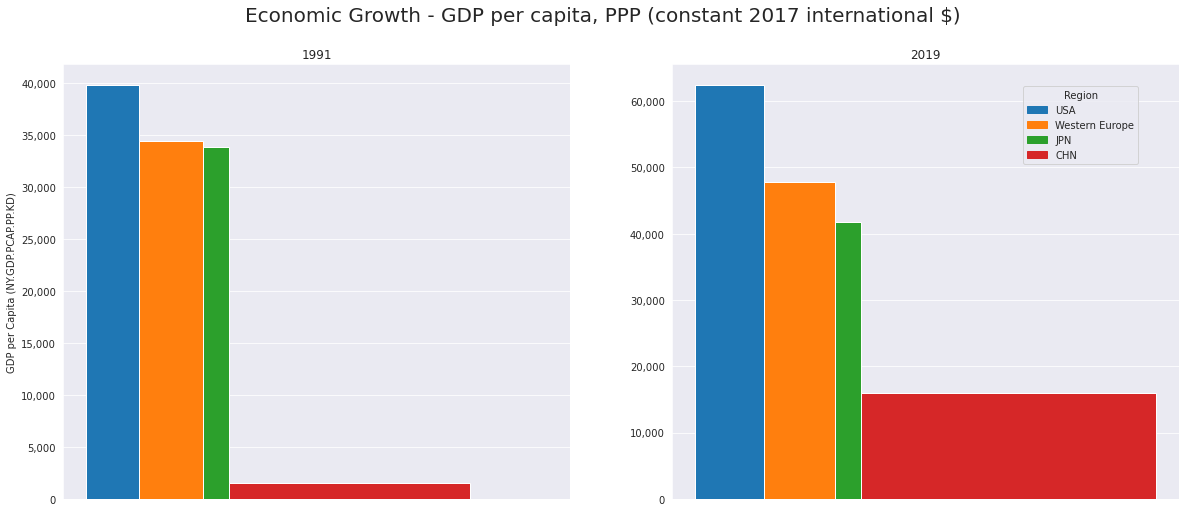

In [325]:
chart_data_start = get_chart_data(gdp, pop, year_start, query_economist, group_economist, sorting={'by': 'GDP per Capita', 'ascending': False})
sorting_dict = dict(zip(chart_data_start['Region'], chart_data_start['GDP per Capita']))
chart_data_end = get_chart_data(gdp, pop, year_end, query_economist, group_economist, sorting={'by': 'Region', 'ascending': False, 'key': lambda x: x.map(sorting_dict)})
fig, (ax_start, ax_end) = draw_comparison_figure(chart_data_start, chart_data_end)
# ax_start.sharey(ax_end)
ax_start.sharex(ax_end)


## Add More Countries

In [326]:
query_economist_with_more = ('`Country Code`.isin(["USA", "JPN", "CHN", "FRA", "DEU", "GBR", "AUT", '
     '"ESP", "LUX", "ITA", "IRL", "SAS", "CAD", "AUS", "NZL", "DNK", "SWE", "NOR", "FIN", "RUS", "TUR",'
     '"ISL", "IRL", "MCO", "LIE", "POL", "LVA", "EST", "MDA", "CZE", "HUN", "EST", "MNE"])')
def group_economist_with_more(country_code: str) -> str:
    if country_code in ["FRA", "DEU", "AUT", "ESP", "LUX", "ITA", "IRL", "DNK", "SWE", "NOR", "FIN", "ISL", "IRL", "MCO", "LIE", "BEL", "CHE", "GBR"]:
        return "Western Europe & Baltic"
    elif country_code in ["CAD", "AUS", "NZL"]:
        return "Canada - Australia - New Zealand"
    elif country_code in ["POL", "LVA", "EST", "MDA", "CZE", "HUN", "MNE"]:
        return "Eastern Europe"
    else:
        return get_country_by_code(country_code)
# Add ex-Commonwealth
# Add Eastern Europe

In [327]:
list_countries = ["USA", "JPN", "CHN", "FRA", "DEU", "GBR", "AUT", "ESP", "LUX", "ITA",
                             "IRL", "DNK", "SWE", "NOR", "FIN", "RUS", "SAS", "TUR",
                             "BEL", "CHE", "SSA"]

query_economist_with_more = f'`Country Code`.isin({list_countries})'


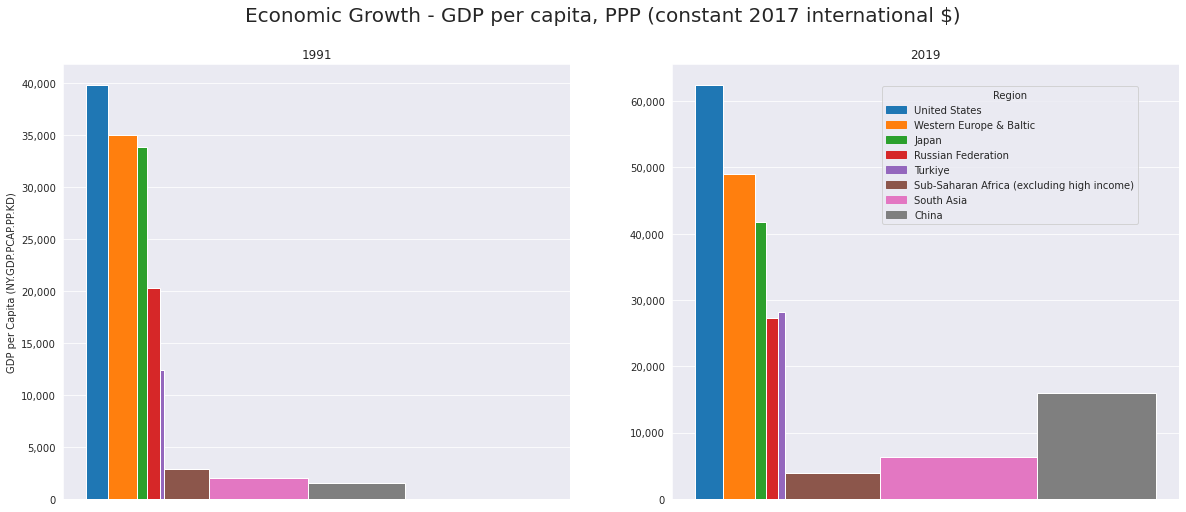

In [328]:
chart_data_start = get_chart_data(gdp, pop, year_start, query_economist_with_more, group_economist_with_more, sorting={'by': 'GDP per Capita', 'ascending': False})
sorting_dict = dict(zip(chart_data_start['Region'], chart_data_start['GDP per Capita']))
chart_data_end = get_chart_data(gdp, pop, year_end, query_economist_with_more, group_economist_with_more, sorting={'by': 'Region', 'ascending': False, 'key': lambda x: x.map(sorting_dict)})
fig, (ax_start, ax_end) = draw_comparison_figure(chart_data_start, chart_data_end)
# ax_start.sharey(ax_end)
ax_start.sharex(ax_end)



In [422]:
def group_european_union(country_code: str) -> str:
    if country_code in ["DNK", "SWE", "NOR", "FIN"]:
        return "Baltic"
    elif country_code in ["CAD", "AUS", "NZL"]:
        return "Canada - Australia - New Zealand"
    elif country_code in ["POL", "LVA", "EST", "MDA", "CZE", "HUN", "MNE", "SVK", "BLR", "UKR"]:
        return "Eastern Europe"
    else:
        return get_country_by_code(country_code)

list_countries = ["USA", "EUU", "DNK", "SWE", "NOR", "FIN", "RUS", 
                  "POL", "UKR", "BEL", "CZE", "HUN",
                  "TUR", ]

query_europe = f'`Country Code`.isin({list_countries})'


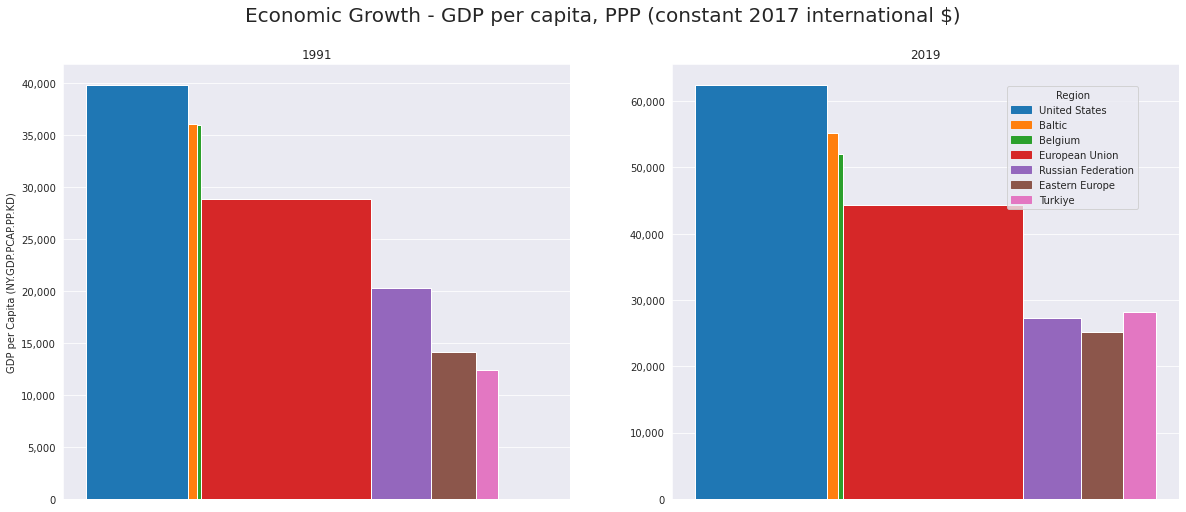

In [423]:
chart_data_start = get_chart_data(gdp, pop, year_start, query_europe, group_european_union, sorting={'by': 'GDP per Capita', 'ascending': False})
sorting_dict = dict(zip(chart_data_start['Region'], chart_data_start['GDP per Capita']))
chart_data_end = get_chart_data(gdp, pop, year_end, query_europe, group_european_union, sorting={'by': 'Region', 'ascending': False, 'key': lambda x: x.map(sorting_dict)})
fig, (ax_start, ax_end) = draw_comparison_figure(chart_data_start, chart_data_end)
# ax_start.sharey(ax_end)
ax_start.sharex(ax_end)



In [424]:
world_bank_data[world_bank_data['Country Name'] == "Ukraine"]['Country Code']

1015    UKR
1016    UKR
1017    UKR
1018    UKR
1019    UKR
Name: Country Code, dtype: object

In [425]:
world_bank_data[['Country Name', 'Country Code']].sample(15)

,Country Name,Country Code
904,Sri Lanka,LKA
675,Myanmar,MMR
907,St. Kitts and Nevis,KNA
49,Aruba,ABW
15,American Samoa,ASM
819,Samoa,WSM
974,Togo,TGO
35,Argentina,ARG
1294,Small states,SST
1299,South Asia,SAS


In [426]:
def group_income(country_code: str) -> str:
    return get_country_by_code(country_code)

list_countries = ["UMC", "MIC", "HIC", "LMC"]

query_income = f'`Country Code`.isin({list_countries})'


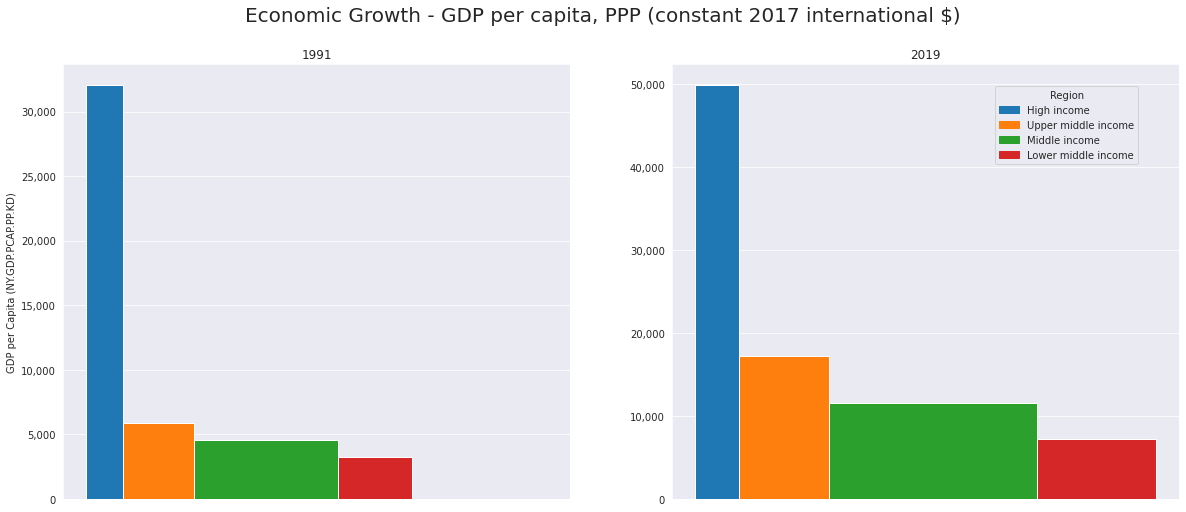

In [427]:
chart_data_start = get_chart_data(gdp, pop, year_start, query_income, group_income, sorting={'by': 'GDP per Capita', 'ascending': False})
sorting_dict = dict(zip(chart_data_start['Region'], chart_data_start['GDP per Capita']))
chart_data_end = get_chart_data(gdp, pop, year_end, query_income, group_income, sorting={'by': 'Region', 'ascending': False, 'key': lambda x: x.map(sorting_dict)})
fig, (ax_start, ax_end) = draw_comparison_figure(chart_data_start, chart_data_end)
# ax_start.sharey(ax_end)
ax_start.sharex(ax_end)



In [104]:
Baltic: DNK SWE NOR FIN
Balkan SVK SVN BGR SRB XKX
Eastern Europe LVA EST MDA CZE HUN POL EST
Central Asian TKM UZB MNG
South Asian: BGD IND

SyntaxError: invalid syntax (<ipython-input-104-b33f0ac7a044>, line 1)